<a href="https://colab.research.google.com/github/pablovitoria/business_analysis_structured_data/blob/main/scripts/A1%3A%20Modeling%20Case%20Study%20-%20Bike%20Rentals%20in%20Chicago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Notebook set-up
# Cloning GitHub Repo
!git clone https://github.com/pablovitoria/business_analysis_structured_data

# Changing directory
import os
repo_name = '/content/business_analysis_structured_data'
os.chdir(repo_name)

# Checking results
print(f"Current working directory changed to: {os.getcwd()}")

fatal: destination path 'business_analysis_structured_data' already exists and is not an empty directory.
Current working directory changed to: /content/business_analysis_structured_data


In [18]:
# importing packages
import pandas as pd                                  # data science essentials
import matplotlib.pyplot as plt                      # data viz
import seaborn as sns                                # enhanced data viz
import statsmodels.formula.api as smf                # linear modeling
from sklearn.model_selection import train_test_split # train/test split
import sklearn.linear_model                          # faster linear modeling
import numpy as np                                   # mathematical essentials

# Suppressing user warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Storing the path to the dataset
file = "./datasets/bike_rentals.xlsx"


# Reading the file into Python through pandas
bikerentals = pd.read_excel(io = file,
                            usecols = range(1, 15)) # omitting ID column

bikerentals.head(n=5)

,Month,Day of Week,Hour,Temperature,Humidity,Wind Speed,Visibility,Dew Point Temperature,UV Index,Rainfall,Snowfall,Seasons,Holiday,RENTALS
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,Winter,Yes,221
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,Winter,Yes,130
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,Winter,Yes,268
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,Winter,Yes,335
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,Winter,Yes,299


In [19]:
# Make all column names lowercase and replace spaces
bikerentals.columns = (
    bikerentals.columns
    .str.lower()
    .str.replace(" ", "_")
)

In [22]:
bikerentals["holiday"] = (
    bikerentals["holiday"]
    .str.strip()
    .str.lower()
    .map({"yes": 1, "no": 0})
)

In [24]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   month                  1029 non-null   object 
 1   day_of_week            1029 non-null   object 
 2   hour                   1029 non-null   int64  
 3   temperature            1029 non-null   float64
 4   humidity               1029 non-null   int64  
 5   wind_speed             1029 non-null   float64
 6   visibility             1029 non-null   int64  
 7   dew_point_temperature  1029 non-null   float64
 8   uv_index               1029 non-null   float64
 9   rainfall               1029 non-null   float64
 10  snowfall               1029 non-null   float64
 11  seasons                1029 non-null   object 
 12  holiday                1029 non-null   int64  
 13  rentals                1029 non-null   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 112.7+ 

In [20]:
bikerentals.head(n=5)

,month,day_of_week,hour,temperature,humidity,wind_speed,visibility,dew_point_temperature,uv_index,rainfall,snowfall,seasons,holiday,rentals
0,Jan,Sunday,0,-3.2,40,0.5,1358,-14.9,0.00,0.0,0.0,Winter,Yes,221
1,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,Winter,Yes,130
2,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,Winter,Yes,268
3,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,Winter,Yes,335
4,Jan,Sunday,17,1.8,33,3.3,1913,-12.8,0.18,0.0,0.0,Winter,Yes,299


In [13]:
bikerentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Month                  1029 non-null   object 
 1   Day of Week            1029 non-null   object 
 2   Hour                   1029 non-null   int64  
 3   Temperature            1029 non-null   float64
 4   Humidity               1029 non-null   int64  
 5   Wind Speed             1029 non-null   float64
 6   Visibility             1029 non-null   int64  
 7   Dew Point Temperature  1029 non-null   float64
 8   UV Index               1029 non-null   float64
 9   Rainfall               1029 non-null   float64
 10  Snowfall               1029 non-null   float64
 11  Seasons                1029 non-null   object 
 12  Holiday                1029 non-null   object 
 13  RENTALS                1029 non-null   int64  
dtypes: float64(6), int64(4), object(4)
memory usage: 112.7+ 

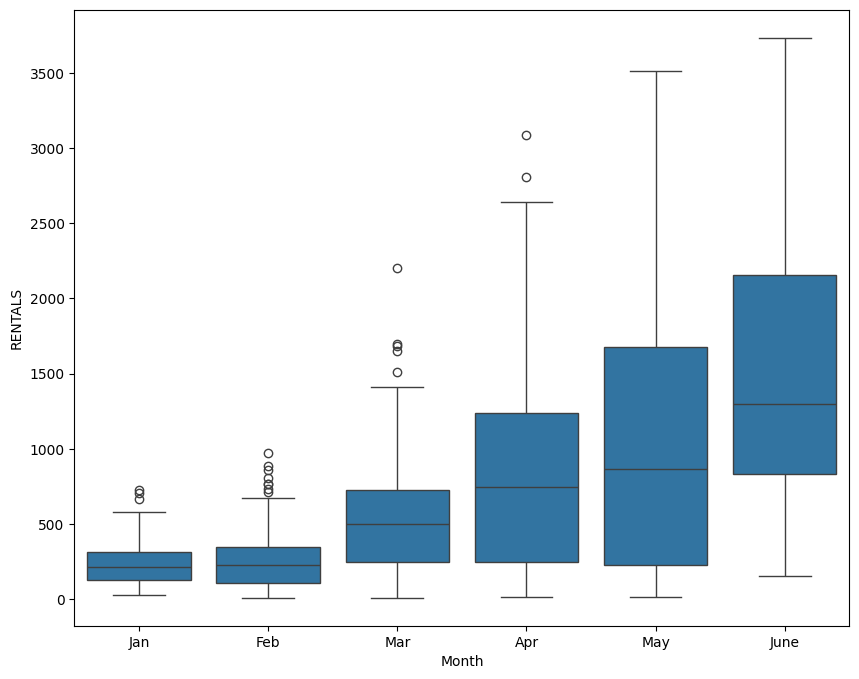

In [16]:
    fig, ax = plt.subplots(figsize = (10, 8))

    sns.boxplot(x    = 'Month',
                y    = 'RENTALS',
                data = bikerentals)

    plt.suptitle("")
    plt.show()

- Seasonal activity detected
- data from Jan to June in the dataset